In [ ]:
from google.colab import drive

drive.mount('/content/drive')

In [ ]:
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    token=""
    !rm -rf dreamix
    !rm -rf sample_data
    !git clone https://{token}@github.com/chemcognition-lab/dreamix.git
    %cd dreamix
    !pip install -r colab_requirements.txt
    sys.path.append('/content/dreamix/src')
    fname = f'' 
else:
    print('Not in colab, assuming your have your kernel setup')
    sys.path.append("../src")
    fname = f'../' 

In [ ]:
!pip install pubchempy
!pip install wget
!pip install rdkit
!pip install pyrfume
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn
!pip install umap-learn
!pip install descriptastorus

In [2]:
import pandas as pd
import rdkit.Chem as Chem
from rdkit.Chem import rdchem
import seaborn as sns
import matplotlib.pyplot as plt

from rdkit.Chem.rdMolDescriptors import GetMorganFingerprintAsBitVect
from descriptastorus.descriptors.DescriptorGenerator import MakeGenerator
from dataloader.representations.features import parse_status#, rdkit2d_normalized_features
from rdkit.Chem.Descriptors import ExactMolWt
import umap

import numpy as np
from sklearn.decomposition import PCA
from dataloader import DataLoader

import matplotlib as mpl
from collections import Counter
mpl.rcParams['figure.facecolor'] = 'white'

ModuleNotFoundError: No module named 'dataloader'

In [3]:
def get_elements(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        elements = {atom.GetSymbol() for atom in mol.GetAtoms()}
        return tuple(sorted(elements))
    else:
        return []
    
def is_chiral(mol):
    chiral_centers = Chem.FindMolChiralCenters(mol, includeUnassigned=True)
    return len(chiral_centers) > 0

def check_cis_trans_isomerism(mol):
    has_cis_trans = False
    for bond in mol.GetBonds():
        # Check if the bond is a double bond
        if bond.GetBondType() == rdchem.BondType.DOUBLE:
            # Check if the double bond has stereochemistry information
            stereo = bond.GetStereo()
            if stereo in [rdchem.BondStereo.STEREOZ, rdchem.BondStereo.STEREOE, rdchem.BondStereo.STEREOCIS, rdchem.BondStereo.STEREOTRANS]:
                has_cis_trans = True
                break

    return has_cis_trans

def rdkit2d_normalized_features(smiles):
    generator = MakeGenerator((f"rdkit2dhistogramnormalized",))
    fps = parse_status(generator, smiles)
    return fps

def get_pna(df):
    df_rdkit2d_norm = pd.DataFrame(columns = ['Dataset', 'Mixture Label']+[f"rdkit2d_norm_{i}" for i in range(43)]+['min', 'max', 'mean', 'std'])

    for i in range(len(df)):
        df_rdkit2d_norm.loc[i, 'Dataset'] = df.loc[i, 'Dataset']
        df_rdkit2d_norm.loc[i, 'Mixture Label'] = df.loc[i, 'Mixture Label']
        for j in range(43):
            if not pd.isnull(df[f"smi_{j}"][i]):
                df_rdkit2d_norm.loc[i, f"rdkit2d_norm_{j}"] = rdkit2d_normalized_features(df[f"smi_{j}"][i])
            else:
                df_rdkit2d_norm.loc[i, f"rdkit2d_norm_{j}"] = None

    assert len(df_rdkit2d_norm) == len(df)

    df_rdkit2d_norm['min'] = None
    df_rdkit2d_norm['max'] = None
    df_rdkit2d_norm['avg'] = None
    df_rdkit2d_norm['std'] = None

    # Set dtype to object to hold arrays
    df_rdkit2d_norm['min'] = df_rdkit2d_norm['min'].astype(object)
    df_rdkit2d_norm['max'] = df_rdkit2d_norm['max'].astype(object)
    df_rdkit2d_norm['avg'] = df_rdkit2d_norm['avg'].astype(object)
    df_rdkit2d_norm['std'] = df_rdkit2d_norm['std'].astype(object)

    for i in range(len(df_rdkit2d_norm)):
        all_features = []
        for j in range(43):
            if df_rdkit2d_norm[f"rdkit2d_norm_{j}"][i] != None:
                all_features.append(df_rdkit2d_norm[f"rdkit2d_norm_{j}"][i])

        min_features = np.min(all_features, axis=0)
        max_features = np.max(all_features, axis=0)
        avg_features = np.mean(all_features, axis=0)
        std_features = np.std(all_features, axis=0)

        assert len(min_features) == len(max_features) == len(avg_features) == len(std_features) == 200

        df_rdkit2d_norm.at[i, 'min'] = min_features
        df_rdkit2d_norm.at[i, 'max'] = max_features
        df_rdkit2d_norm.at[i, 'avg'] = avg_features
        df_rdkit2d_norm.at[i, 'std'] = std_features

    df_rdkit2d_norm['PNA'] = None
    df_rdkit2d_norm['PNA'] = df_rdkit2d_norm['PNA'].astype(object)

    for i in range(0, len(df_rdkit2d_norm)):
        min_arr = df_rdkit2d_norm['min'][i]
        max_arr = df_rdkit2d_norm['max'][i]
        avg_arr = df_rdkit2d_norm['avg'][i]
        std_arr = df_rdkit2d_norm['std'][i]
        
        PNA = np.concatenate((min_arr, max_arr, avg_arr, std_arr), axis=0)
        df_rdkit2d_norm.at[i, 'PNA'] = PNA
        assert len(df_rdkit2d_norm['PNA'][i]) == 200*4
    
    return df_rdkit2d_norm

# EDA of Mixture based on SMILES strings

In [4]:
title = "DREAM Challenge Mixture Dataset"
df = pd.read_csv("datasets/competition/mixture_smi_definitions_clean.csv")
df_rdkit2d_norm = get_pna(df)

In [7]:
umap_model = umap.UMAP(metric = "cosine",
                       densmap=True,
                       random_state=42,
                       low_memory = False)
X_umap = umap_model.fit_transform(list(df_rdkit2d_norm['PNA']))
df_rdkit2d_norm["UMAP_0"], df_rdkit2d_norm["UMAP_1"] = X_umap[:,0], X_umap[:,1]

c:\Users\SeanPark\miniconda3\envs\dreamix\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Text(0.5, 1.0, 'DREAM Challenge Mixture Dataset Distribution')

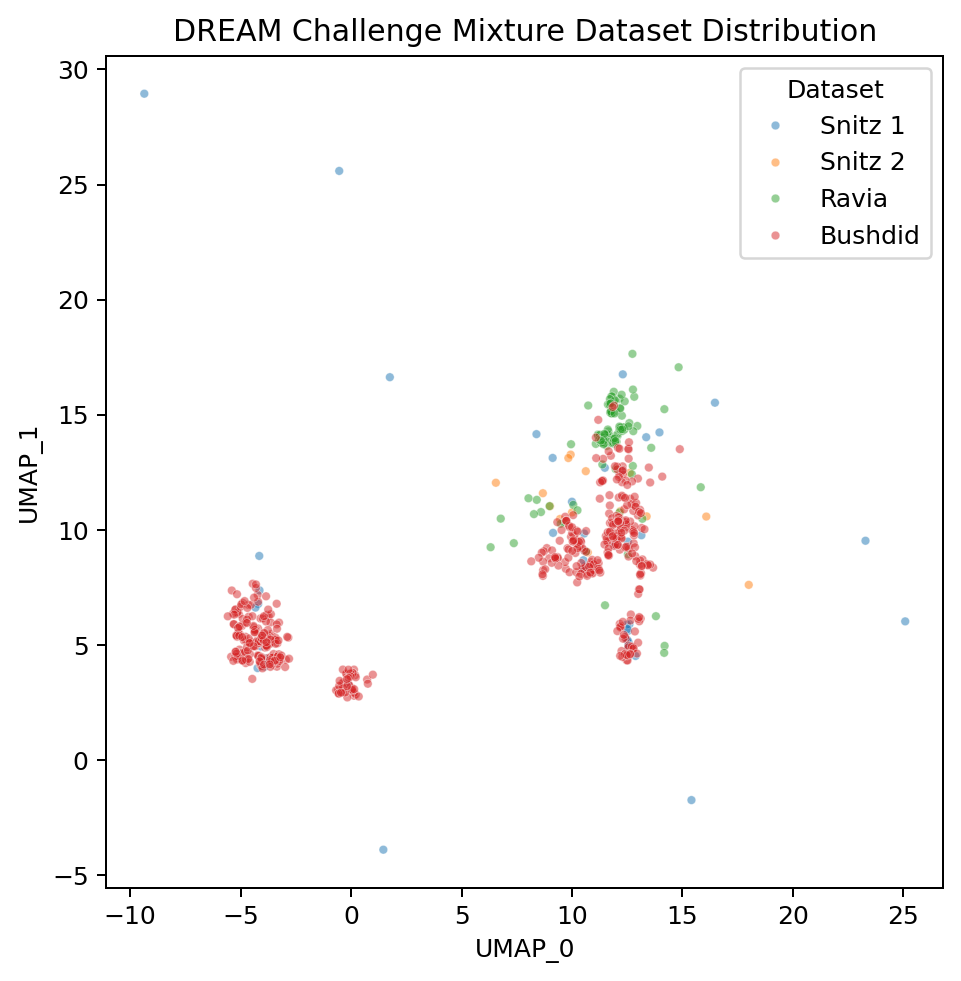

In [8]:
fig, ax = plt.subplots(1,1, figsize=(6,6), dpi=180)
# g = sns.scatterplot(x="UMAP_0", y="UMAP_1", data=df, ax=ax, hue=df['Intensity1'], s=12, alpha=0.8, palette='coolwarm')
g = sns.scatterplot(x="UMAP_0", y="UMAP_1", hue="Dataset", data=df_rdkit2d_norm, ax=ax, s=12, alpha=0.5)
ax.legend(title="Dataset")
ax.set_title(f"{title} Distribution")

[0.26599702 0.11970151]


Text(0, 0.5, 'PC1 (12.0%)')

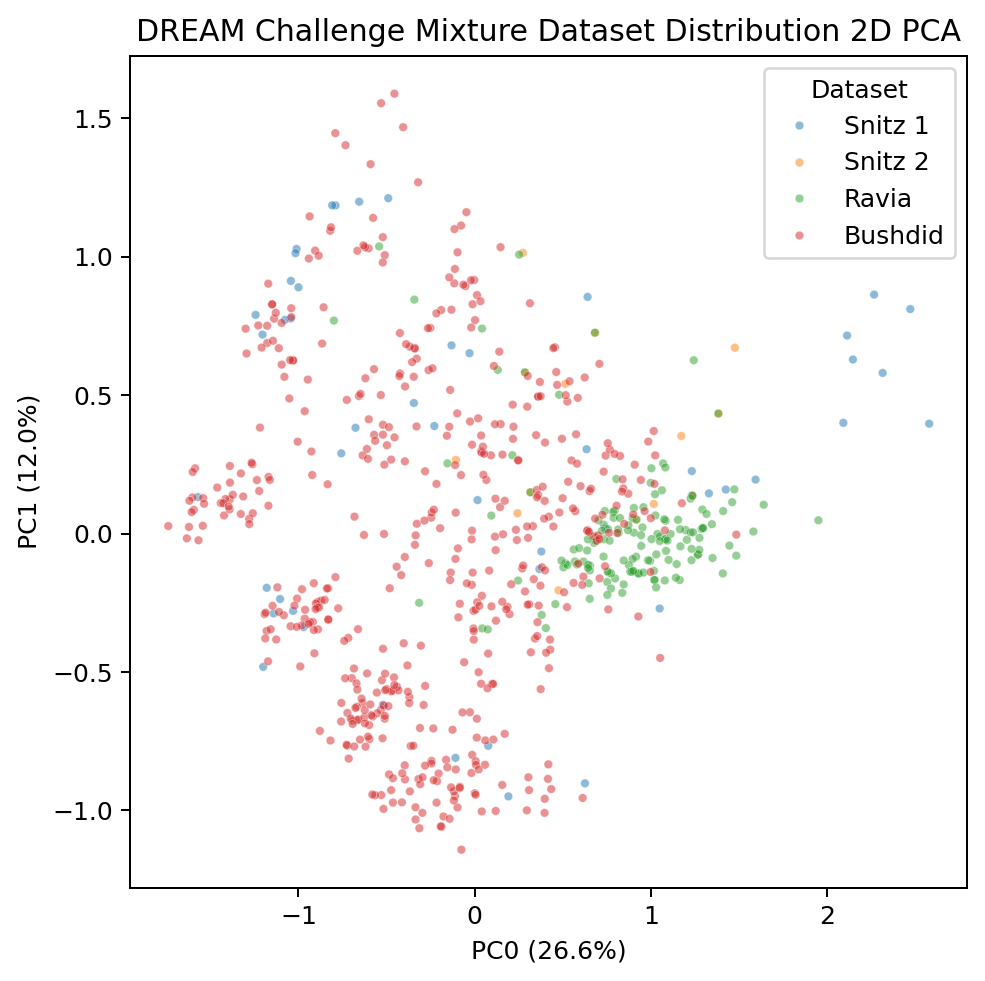

In [10]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(list(df_rdkit2d_norm['PNA']))
print(pca.explained_variance_ratio_)
fig, ax = plt.subplots(1,1, figsize=(6,6), dpi=180)
# g = sns.scatterplot(x=principalComponents[:, 0], y=principalComponents[:, 1], ax=ax, hue=df["Intensity1"], s=12, alpha=0.8, palette='coolwarm')
g = sns.scatterplot(x=principalComponents[:, 0], y=principalComponents[:, 1], ax=ax, s=12, alpha=0.5, hue=df_rdkit2d_norm['Dataset'])
ax.set_title(f"{title} Distribution 2D PCA")
ax.set_xlabel(f"PC0 ({pca.explained_variance_ratio_[0]*100:.01f}%)")
ax.set_ylabel(f"PC1 ({pca.explained_variance_ratio_[1]*100:.01f}%)")

Text(0.5, 1.0, 'DREAM Challenge Mixture Dataset 2D PC Cumulative')

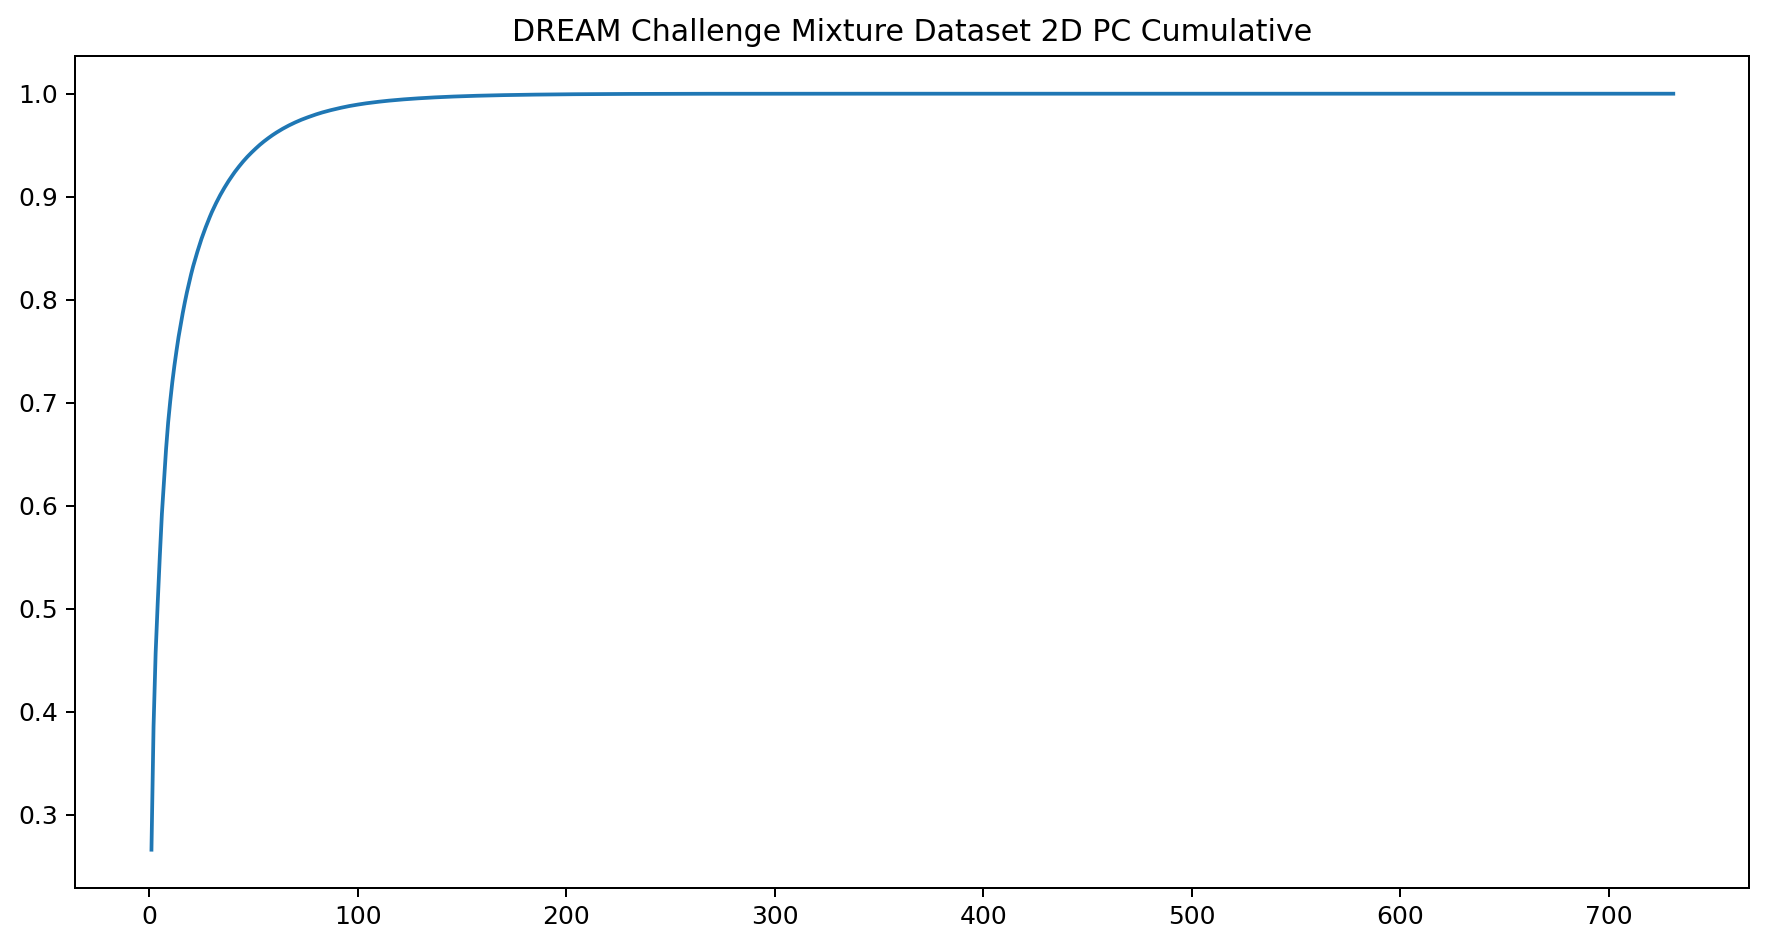

In [11]:
pca = PCA(n_components=len(df))
principalComponents = pca.fit_transform(list(df_rdkit2d_norm['PNA']))
cumulative_variance_explained = np.cumsum(pca.explained_variance_ratio_)
fig, ax = plt.subplots(1,1, figsize=(12,6), dpi=180)
g = sns.lineplot(x=range(1,len(cumulative_variance_explained)+1), y=cumulative_variance_explained)
ax.set_title(f"{title} 2D PC Cumulative")

# EDA of mono-molecule based on SMILES string

In [1]:
df1 = pd.read_csv("datasets/mayhew_2022/mayhew_2022_combined.csv")
df1['rdkit'] = df.apply(lambda row: Chem.MolFromSmiles(row['IsomericSMILES']), axis=1)

NameError: name 'pd' is not defined

In [ ]:
df['mw'] = df.apply(lambda row: ExactMolWt(row['rdkit']), axis=1)

if True:
    fig, ax = plt.subplots(1,3, figsize=(18,6), dpi=300)
    g = sns.histplot(df['mw'], ax=ax[0], binwidth=5, color='green')
    g.set_yscale("log")
    ax[0].set_title("Mayhew MW Distribution")
    ax[0].set_xlim([0,1200])
    ax[0].set_ylim([0,100])

    
    
    g = sns.histplot(df[df['is_odor'] == 0]['mw'], ax=ax[1], binwidth=5, color='b')
    g.set_yscale("log")
    ax[1].set_title("Mayhew MW Distribution")
    ax[1].set_xlim([0,1200])
    ax[1].set_ylim([0, 100])

    g = sns.histplot(df[df['is_odor'] == 1]['mw'], ax=ax[2], binwidth=5, color='orange')
    g.set_yscale("log")
    ax[2].set_title("Mayhew MW Distribution")
    ax[2].set_xlim([0,1200])
    ax[2].set_ylim([0, 100])



else:
    fig, ax = plt.subplots(1,1, figsize=(6,6), dpi=300)
    g = sns.histplot(df['mw'], ax=ax, binwidth=5, color='green')
    ax.set_title("Leffingwell MW Distribution")
    ax.set_xlim([0,450])
    g.set_yscale("log")
    #ax.set_ylim([0, 100])